# RNN mini-Project Pytorch

**keywords:** Pytorch, SpaCy, RNN, bidirectional LSTM, GloVe, packed_padded_sequence, classification, class_weight

The dataset is from kaggle [emotions-dataset-for-nlp](https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp). The goal is to classify a text among six emotions ('surprise', 'joy', 'sadness', 'anger', 'love', 'fear'). 

This notebook is based on the [tutorials](https://github.com/bentrevett/pytorch-sentiment-analysis) by Ben Trevett who has done an amazing work.

In [1]:
import numpy as np
import pandas as pd
import time
import random
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
df_train = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/train.txt", 
                       delimiter=';', header=None, names=['sentence','label'])
df_test = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/test.txt", 
                      delimiter=';', header=None, names=['sentence','label'])
df_val = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/val.txt", 
                     delimiter=';', header=None, names=['sentence','label'])

df = pd.concat([df_train,df_test,df_val])

df.head()

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


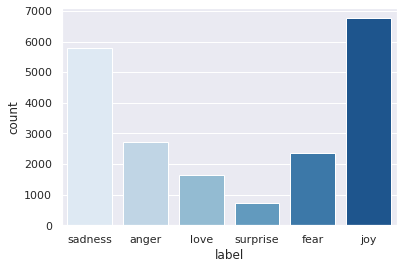

In [3]:
# take a glipse of how many instances in each class we have
sns.countplot(df['label'], palette="Blues");

We can observe that we have more 'joy' and 'sadness' texts.

In [4]:
# save it as csv
df.to_csv("data.csv", index=False)

# Data to torch DataLoaders

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext

torch.backends.cudnn.deterministic = True

In [6]:
# General Settings
RANDOM_SEED = 12345
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 20_000
BATCH_SIZE = 128

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

We will use the SpaCy tokenizer. Moreover, we will use packed_padded_sequence which will make our net more computetionaly efficient (but it does not effect the accuracy).

In [7]:
# Define the Label and Text field formatters:
TEXT = torchtext.data.Field(sequential=True,
                            tokenize='spacy',
                            include_lengths=True) # necessary for packed_padded_sequence

LABEL = torchtext.data.LabelField()


# Process the dataset:
fields = [('sentence', TEXT), ('label', LABEL)]

dataset = torchtext.data.TabularDataset(
    path="./data.csv", format='csv',
    skip_header=True, fields=fields)

In [8]:
# Split the dataset into training, validation, and test partitions:

train_data, valid_data, test_data = dataset.split(
    split_ratio=[0.8, 0.1, 0.1],
    random_state=random.seed(RANDOM_SEED))

print(f'Num Train: {len(train_data)}')
print(f'Num Valid: {len(valid_data)}')
print(f'Num Test: {len(test_data)}')

Num Train: 16000
Num Valid: 2000
Num Test: 2000


In [9]:
# Build the vocabulary based on the top "VOCABULARY_SIZE" words:

TEXT.build_vocab(train_data, max_size=VOCABULARY_SIZE)
LABEL.build_vocab(train_data)

print(f'Vocabulary size: {len(TEXT.vocab)}')
print(f'Number of classes: {len(LABEL.vocab)}')

Vocabulary size: 15164
Number of classes: 6


The 6 labels coresponding to the 6 emotions: 'anger', 'sadness', 'love', 'fear', 'joy', 'surprise'.

In [10]:
LABEL.vocab.freqs

Counter({'surprise': 570,
         'joy': 5405,
         'sadness': 4655,
         'anger': 2140,
         'love': 1311,
         'fear': 1919})

In [11]:
# get the dictionary that maps the emotions to numbers
desc2targ = LABEL.vocab.stoi

targ2desc = {v: k for k, v in desc2targ.items()} # inverse dictionary

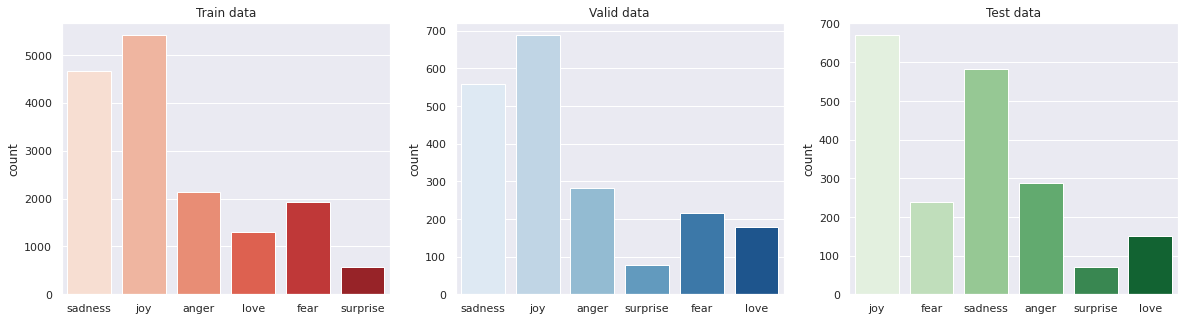

In [12]:
# create temporal iterators to count the number of categories in the 3 sets
for _,j in torchtext.data.BucketIterator(train_data, batch_size=len(train_data)): train_ys = j   
for _,j in torchtext.data.BucketIterator(valid_data, batch_size=len(valid_data)): valid_ys = j
for _,j in torchtext.data.BucketIterator(test_data,  batch_size=len(test_data)) : test_ys = j
    
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(pd.Series(np.asarray(train_ys)).map(targ2desc) , ax=ax[0], palette="Reds")
ax[0].set_title("Train data")
sns.countplot(pd.Series(np.asarray(valid_ys)).map(targ2desc) , ax=ax[1], palette="Blues")
ax[1].set_title("Valid data")
sns.countplot(pd.Series(np.asarray(test_ys)).map(targ2desc) , ax=ax[2], palette="Greens");
ax[2].set_title("Test data");

The split has been done nicely, even if we had from the beginning imbalanced dataset (which we still have). 

So to address the imbalanced dataset, we will use class weights in the cross entropy.

In [13]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(y=np.asarray(train_ys), 
                               class_weight="balanced", 
                               classes=np.asarray(train_ys.unique()))    
class_weights = torch.FloatTensor(weights)

class_weights = class_weights.to(DEVICE)

In [14]:
# Make data loaders:
train_loader, valid_loader, test_loader = torchtext.data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    sort_within_batch=True, # necessary for packed_padded_sequence
    sort_key=lambda x: len(x.sentence)) 

In [15]:
# Testing the iterators: 
#note: that the number of rows depends on the longest document in the respective batch
print('Train')
for batch in train_loader:
    print(f'Text matrix size: {batch.sentence[0].size()}')
    print(f'Target vector size: {batch.label.size()}')
    break
    
print('\nValid:')
for batch in valid_loader:
    print(f'Text matrix size: {batch.sentence[0].size()}')
    print(f'Target vector size: {batch.label.size()}')
    break
    
print('\nTest:')
for batch in test_loader:
    print(f'Text matrix size: {batch.sentence[0].size()}')
    print(f'Target vector size: {batch.label.size()}')
    break

Train
Text matrix size: torch.Size([38, 128])
Target vector size: torch.Size([128])

Valid:
Text matrix size: torch.Size([6, 128])
Target vector size: torch.Size([128])

Test:
Text matrix size: torch.Size([6, 128])
Target vector size: torch.Size([128])


# Model

First we will use a bidirectional LSTM model and we will train our own embeddings.

In [19]:
class RNNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

In [20]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = len(LABEL.vocab)  #6 categories

N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNNet(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

model = model.to(DEVICE)

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,311,558 trainable parameters


In [22]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [23]:
def train(model, iterator, optimizer, criterion, device, class_weights=None):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        sentence, labels = batch 
        text, text_lengths = sentence
        
        text = text.to(device)
        text_lengths = text_lengths.to(device)
        labels = labels.to(device)
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, labels, weight=class_weights)
        
        optimizer.zero_grad()
        
        acc = accuracy(predictions, labels)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [24]:
def evaluate(model, iterator, criterion, device, class_weights=None):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            sentence, labels = batch 
            text, text_lengths = sentence
            
            text = text.to(device)
            text_lengths = text_lengths.to(device)
            labels = labels.to(device)

            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, labels, weight=class_weights)
            
            acc = accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [25]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [26]:
N_EPOCHS = 20
LEARNING_RATE = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = F.cross_entropy

best_valid_loss = float('inf')

for epoch in tqdm(range(N_EPOCHS)):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, DEVICE, class_weights)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, DEVICE, class_weights)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'bst-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 1.765 | Train Acc: 17.69%
	 Val. Loss: 1.630 |  Val. Acc: 30.52%
Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 1.546 | Train Acc: 29.48%
	 Val. Loss: 1.167 |  Val. Acc: 43.73%
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 1.235 | Train Acc: 43.10%
	 Val. Loss: 0.895 |  Val. Acc: 53.89%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.982 | Train Acc: 55.18%
	 Val. Loss: 0.619 |  Val. Acc: 71.85%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 0.758 | Train Acc: 66.44%
	 Val. Loss: 0.458 |  Val. Acc: 81.60%
Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 0.615 | Train Acc: 73.72%
	 Val. Loss: 0.388 |  Val. Acc: 85.50%
Epoch: 07 | Epoch Time: 0m 2s
	Train Loss: 0.510 | Train Acc: 77.88%
	 Val. Loss: 0.301 |  Val. Acc: 88.25%
Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 0.440 | Train Acc: 81.23%
	 Val. Loss: 0.263 |  Val. Acc: 88.44%
Epoch: 09 | Epoch Time: 0m 2s
	Train Loss: 0.367 | Train Acc: 83.84%
	 Val. Loss: 0.249 |  Val. Acc: 88.94%
Epoch: 10 | Epoch Time: 0m 2

How well the model generalizes.

In [27]:
model.load_state_dict(torch.load('bst-model.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE, class_weights)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.234 | Test Acc: 91.42%


# Now let's use the pre-trained GloVe vectors (pre-trained embeddings), in the same model.

In [38]:
# Define the Label and Text field formatters:
TEXT = torchtext.data.Field(tokenize='spacy',
                            include_lengths=True) # necessary for packed_padded_sequence

LABEL = torchtext.data.LabelField()


# Process the dataset:
fields = [('sentence', TEXT), ('label', LABEL)]

dataset = torchtext.data.TabularDataset(
    path="./data.csv", format='csv',
    skip_header=True, fields=fields)

In [39]:
# Split the dataset into training, validation, and test partitions:

train_data, valid_data, test_data = dataset.split(
    split_ratio=[0.8, 0.1, 0.1],
    random_state=random.seed(RANDOM_SEED))

print(f'Num Train: {len(train_data)}')
print(f'Num Valid: {len(valid_data)}')
print(f'Num Test: {len(test_data)}')

Num Train: 16000
Num Valid: 2000
Num Test: 2000


In [40]:
# Build the vocabulary based on the top "VOCABULARY_SIZE" words:

TEXT.build_vocab(train_data, max_size=VOCABULARY_SIZE,
                vectors = "glove.6B.100d",unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

print(f'Vocabulary size: {len(TEXT.vocab)}')
print(f'Number of classes: {len(LABEL.vocab)}')

Vocabulary size: 15164
Number of classes: 6


In [41]:
# get the dictionary that maps the emotions to numbers
desc2targ = LABEL.vocab.stoi
targ2desc = {v: k for k, v in desc2targ.items()} # inverse dictionary

In [42]:
# Make data loaders:
train_loader, valid_loader, test_loader = torchtext.data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    sort_within_batch=True, # necessary for packed_padded_sequence
    sort_key=lambda x: len(x.sentence))

In [77]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(LABEL.vocab)  #6 categories

N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model2 = RNNet(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

model2 = model2.to(DEVICE)

In [78]:
# The final addition is copying the pre-trained word embeddings 
# we loaded earlier into the embedding layer of our model.
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([15164, 100])


In [79]:
# We then replace the initial weights of the embedding layer with the pre-trained embeddings.
model2.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-1.5430, -1.4413,  0.1673,  ..., -0.5967, -0.3163,  1.6066],
        [-0.3076, -0.3158,  0.6217,  ...,  0.0921,  0.6499, -0.0222],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [-0.8502, -0.3114,  0.1293,  ..., -0.4138,  1.1591,  0.0713],
        [-0.1438,  0.8681, -0.7219,  ...,  0.0553, -0.4339,  0.3486],
        [-0.6644, -0.3045,  0.6151,  ...,  0.1404,  0.5788, -0.0333]],
       device='cuda:0')

In [80]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model2.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model2.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [81]:
N_EPOCHS = 20
LEARNING_RATE = 1e-3
optimizer = torch.optim.Adam(model2.parameters(), lr=LEARNING_RATE)
criterion = F.cross_entropy

best_valid_loss = float('inf')

for epoch in tqdm(range(N_EPOCHS)):

    start_time = time.time()
    
    train_loss, train_acc = train(model2, train_loader, optimizer, criterion, DEVICE)
    valid_loss, valid_acc = evaluate(model2, valid_loader, criterion, DEVICE)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model2.state_dict(), 'bst-model2.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 1.477 | Train Acc: 42.26%
	 Val. Loss: 1.246 |  Val. Acc: 52.77%
Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 1.035 | Train Acc: 62.17%
	 Val. Loss: 0.606 |  Val. Acc: 78.42%
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 0.645 | Train Acc: 77.39%
	 Val. Loss: 0.359 |  Val. Acc: 87.07%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.440 | Train Acc: 84.67%
	 Val. Loss: 0.239 |  Val. Acc: 90.94%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 0.339 | Train Acc: 87.94%
	 Val. Loss: 0.192 |  Val. Acc: 92.43%
Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 0.270 | Train Acc: 90.16%
	 Val. Loss: 0.159 |  Val. Acc: 93.09%
Epoch: 07 | Epoch Time: 0m 2s
	Train Loss: 0.235 | Train Acc: 91.04%
	 Val. Loss: 0.130 |  Val. Acc: 93.78%
Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 0.211 | Train Acc: 91.52%
	 Val. Loss: 0.129 |  Val. Acc: 93.55%
Epoch: 09 | Epoch Time: 0m 2s
	Train Loss: 0.177 | Train Acc: 92.77%
	 Val. Loss: 0.122 |  Val. Acc: 93.55%
Epoch: 10 | Epoch Time: 0m 2

In [82]:
# load the best model
model2.load_state_dict(torch.load('bst-model2.pt'))

# evaluate on test set
test_loss, test_acc = evaluate(model2, test_loader, criterion, DEVICE)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.124 | Test Acc: 93.38%


## Notes:
We did not see a big difference between using the pre-trained embeddings or not, one reason could be that each observation is a simple sentence, thus it is not difficult to learn the embeddings.

# Classify a user input

In [83]:
# Prepare the sentence to feed into the network and then get the prediction
import spacy
nlp = spacy.load('en')

def predict_emotion(model, sentence, device):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = model(tensor, length_tensor)
    _, pred = torch.max(prediction, dim=1)
    return targ2desc[int(pred)]

In [84]:
predict_emotion(model2, "This film is terrible", DEVICE)

'sadness'

In [85]:
predict_emotion(model2, "It was a wonderful day", DEVICE)

'joy'

# References:
1. [Emotions-dataset from kaggle](https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp)
2. [Pytorch-sentiment-analysis github repo by Ben Trevett](https://github.com/bentrevett/pytorch-sentiment-analysis)
3. [Deep Learning models github repo by Sebastian Raschka](https://github.com/rasbt/deeplearning-models/tree/master/pytorch_ipynb/rnn)
4. [Pytorch-Deep-Learning github repo by Alfredo Canziani](https://github.com/Atcold/pytorch-Deep-Learning)